In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import deque
from collections import defaultdict
import random


# 1. Data

In [5]:
df_hero_net = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\hero-network.csv")
df_edges = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\edges.csv")
df_nodes = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\nodes.csv")

In [6]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [7]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [8]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


In [9]:
df_nodes.shape

(19090, 2)

In [10]:
n_comics = df_nodes[df_nodes.type == 'comic'].count()
n_heros = df_nodes[df_nodes.type == 'hero'].count()
print(n_comics, n_heros)

node    12651
type    12651
dtype: int64 node    6439
type    6439
dtype: int64


## 1.1 Pre-processing 

We remove extra spaces and '/' at the end of the names in the datasets. 

In [11]:
df_hero_net["hero1"] = df_hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_hero_net["hero2"] = df_hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [12]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [13]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_edges["comic"] = df_edges["comic"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [14]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [15]:
df_nodes["node"] = df_nodes["node"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [16]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


 We fix the 'spider-man/peter parker' error in the datasets.

In [17]:
df_hero_net = df_hero_net.replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', regex=True)

In [18]:
df_nodes.node = df_nodes.node.replace('SPIDER-MAN/PETER PARKERKER','SPIDER-MAN/PETER PARKER', regex=True)

We check if the error is fixed and if there are other similar errors in the datasets.

At first, we check the hero names.

In [19]:
hero_edges = set(df_edges.hero)
hero_heronet = set(df_hero_net.hero1).union(set(df_hero_net.hero2))
hero_nodes = set(df_nodes.loc[df_nodes.type=='hero']['node'])

print(hero_edges - hero_heronet)
print(hero_heronet - hero_edges)

{'JOHNSON, LYNDON BAIN', 'RED WOLF II', 'KULL', 'GIURESCU, RADU', 'CLUMSY FOULUP', 'FENRIS', 'MARVEL BOY II/MARTIN', 'RUNE', 'RANDAK', 'ZANTOR', 'LUNATIK II', 'DEATHCHARGE', 'SEA LEOPARD', 'CALLAHAN, DANNY', 'BLARE', 'BERSERKER II', 'GERVASE, LADY ALYSSA', 'SHARKSKIN'}
set()


In [20]:
print(hero_edges - hero_nodes)
print(hero_nodes - hero_edges)

set()
set()


In [21]:
print(hero_nodes - hero_heronet)
print(hero_heronet - hero_nodes)

{'JOHNSON, LYNDON BAIN', 'RED WOLF II', 'KULL', 'GIURESCU, RADU', 'CLUMSY FOULUP', 'FENRIS', 'MARVEL BOY II/MARTIN', 'RUNE', 'RANDAK', 'ZANTOR', 'LUNATIK II', 'DEATHCHARGE', 'SEA LEOPARD', 'CALLAHAN, DANNY', 'BLARE', 'BERSERKER II', 'GERVASE, LADY ALYSSA', 'SHARKSKIN'}
set()


Then, we check the comic names.

In [22]:
comic_edges = set(df_edges.comic)
comic_nodes = set(df_nodes.loc[df_nodes.type=='comic']['node'])

In [23]:
print(comic_edges-comic_nodes)
print(comic_nodes-comic_edges)

set()
set()


We notice that some hero names are the same as comic names. We therefore decide to add word 'comic' at the end to the comic names equal to those of the heroes, in order to avoid problems in the creation and management of graphs.

In [24]:
equals = hero_edges.intersection(comic_edges)
equals

{'BLADE', 'REBEL', 'SABRE'}

In [25]:
hero_nodes.intersection(comic_nodes)

{'BLADE', 'REBEL', 'SABRE'}

In [26]:
for i in equals:
    df_edges.comic = df_edges.comic.replace(i, i+' comic', regex=True)


## 1.2 First graph

In [27]:
G1 = nx.MultiGraph()

In [28]:
df_hero_net.apply(lambda row: G1.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 574467, dtype: int64

In [29]:
#drop sefl-loops
G1.remove_edges_from(nx.selfloop_edges(G1))

In [30]:
list(G1.edges())[:10]

[('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL")]

In [31]:
dicOfOccurances = {}
for h1,h2 in df_hero_net.to_numpy():
    if h1 != h2:
        if (h1,h2) in dicOfOccurances:
            dicOfOccurances[(h1,h2)] += 1
        else:
            dicOfOccurances[(h1,h2)] = 1


In [32]:
G1_weighted = nx.MultiGraph()

In [33]:
i = 0
for edge in list(G1.edges()):
    try:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/dicOfOccurances[edge], 3))
    except:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/dicOfOccurances[(edge[1], edge[0])],3))


In [34]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA', 0), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 1), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 2), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 3), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 4), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 5), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 6), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 7), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 0), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 1), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 2), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 3), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 4), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 5), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 6), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 0), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 1), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 2), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 3), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 4)

In [35]:
G1_weighted['LITTLE, ABNER']['PRINCESS ZANDA']

AtlasView({0: {'weight': 0.2}, 1: {'weight': 0.2}, 2: {'weight': 0.2}, 3: {'weight': 0.2}, 4: {'weight': 0.2}, 5: {'weight': 0.2}, 6: {'weight': 0.2}, 7: {'weight': 0.2}})

In [36]:
G1_weighted_graph = nx.Graph(G1_weighted)
G1_weighted_graph['LITTLE, ABNER']['PRINCESS ZANDA']

{'weight': 0.2}

In [37]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted_graph, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA'), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR'), 0.333)
(('LITTLE, ABNER', 'IRON MAN/TONY STARK'), 1.0)
(('LITTLE, ABNER', 'GOLDEN-BLADE'), 1.0)
(('LITTLE, ABNER', 'DIXON, GENERAL'), 1.0)
(('LITTLE, ABNER', 'IRON MAN IV/JAMES R.'), 1.0)
(('LITTLE, ABNER', 'JOCASTA'), 1.0)
(('LITTLE, ABNER', 'FUJIKAWA, RUMIKO'), 1.0)
(('LITTLE, ABNER', 'MADAME MENACE/SUNSET'), 1.0)
(('LITTLE, ABNER', 'JACOBS, GLENDA'), 1.0)
(('LITTLE, ABNER', 'WAR MACHINE II/PARNE'), 1.0)
(('LITTLE, ABNER', 'SAPPER'), 1.0)
(('LITTLE, ABNER', 'HOGAN, VIRGINIA PEPP'), 1.0)
(('LITTLE, ABNER', 'BINARY/CAROL DANVERS'), 1.0)
(('LITTLE, ABNER', 'FIN FANG FOOM/MIDGAR'), 1.0)
(('LITTLE, ABNER', 'MANN, DR. J. VERNON'), 0.5)
(('LITTLE, ABNER', 'THOR/DR. DONALD BLAK'), 1.0)
(('LITTLE, ABNER', 'TEMPEST II/NICOLETTE'), 1.0)
(('LITTLE, ABNER', 'JARVIS, EDWIN'), 1.0)


In [38]:
dicOfWeights = {}
for edge in G1_weighted_graph.edges():
    dicOfWeights[edge] = G1_weighted_graph.get_edge_data(edge[0], edge[1])['weight']


In [39]:
print('Number of nodes of the first graph: ' + str(len(G1_weighted_graph.nodes())))
print('Number of edges of the first graph: ' +  str(len(G1_weighted_graph.edges())))

Number of nodes of the first graph: 6421
Number of edges of the first graph: 167100


## 1.3 Second graph

In [40]:
attributes = {}
for elem in df_edges['hero']:
    attributes[elem] = {'type' : 'hero' } 
for elem in df_edges['comic']:
    attributes[elem] = {'type' : 'comic' } 

print('Number of elements in attributes list: ' + str(len(attributes)))

Number of elements in attributes list: 19090


In [41]:
G2 = nx.from_pandas_edgelist(df_edges, 'hero', 'comic')
nx.set_node_attributes(G2, attributes)
print('Number of nodes of the second graph: ' + str(len(G2.nodes())))
print('Number of edges of the second graph: ' +  str(len(G2.edges())))

Number of nodes of the second graph: 19090
Number of edges of the second graph: 96104


In [42]:
nodes, types = zip(*nx.get_node_attributes(G2, 'type').items())
for i in range(10):
    print(nodes[i], types[i])

24-HOUR MAN/EMMANUEL hero
AA2 35 comic
3-D MAN/CHARLES CHAN hero
AVF 4 comic
AVF 5 comic
COC 1 comic
H2 251 comic
H2 252 comic
M/PRM 35 comic
M/PRM 36 comic


## 1.4 TopN

In [43]:
def create_G1_topN(N, df):
    G_topN = G1_weighted_graph.copy()
    most_popular_heros = df.groupby("hero", group_keys=False).count().sort_values(by='comic', ascending = False).head(N)
    notInTopN = set(G1_weighted_graph.nodes()) - set(most_popular_heros.index)
    G_topN.remove_nodes_from(notInTopN)
    return G_topN

In [44]:
def create_G2_topN(N, df):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count").sort_values(by = 'count',ascending=False).head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    
    new_nodes = set(nodes)
    for i in nodes:
        app = list(df_edges.loc[df_edges['hero']==i]['comic'])
        new_nodes.update(app)
        
    G_top_N = G2.subgraph(new_nodes)
    return G_top_N

In [45]:
G1_topN = create_G1_topN(10, df_edges)
len(G1_topN.edges())

45

In [46]:
G2_topN= create_G2_topN(10, df_edges)
len(G2_topN.edges())

10136

# 2. Backend Implementation

## Functionality 1 - extract the graph's features

In [101]:
from collections import Counter

In [179]:
def degree_distG(G):
    degree_G = [G.degree(n) for n in G.nodes()]
    degree_counts = Counter(degree_G)
    return degree_counts

In [180]:
def hubs_G1(G):
    degreeG1 = [G.degree(n) for n in G.nodes()]
    ex_nodes = [n for n in G.nodes() if G.degree(n) > np.percentile(degreeG1,95)]
    return(ex_nodes)

In [181]:
def hubs_G2(G):
    degreeG2 = [G.degree(n) for n in G.nodes()]
    ex_nodes = [n for n in G.nodes() if G.degree(n) > np.percentile(degreeG2,95) and G.nodes[n].get('type', '') == 'comic']
    return(ex_nodes)

In [182]:
def density_G(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    return 2*m/(n*(n-1))

In [183]:
def functionality_1(G, G_type, N):
    if G_type == 1:
        G1_topN = create_G1_topN(N, df_edges)
        
        # number of nodes in the network
        n_nodes_G1_topN = int(G1_topN.number_of_nodes())
        
        # number of collaborations of each superhero with the others
        degree_G1_topN = G1_topN.degree()
        sorted_degree_G1_topN = sorted(degree_G1_topN, key=lambda x: x[1], reverse=True)
    
        # network's density
        density_G1_topN = len(G1_topN.edges())/(n_nodes_G1_topN*(n_nodes_G1_topN-1)/2)

        # network's degree distribution
        degree_dist_G1_topN = degree_distG(G1_topN) 

        #  average degree of the network
        degree_sequence_G1_topN = sorted([deg for i, deg in G1_topN.degree()], reverse=True)
        avg_degree_G1_topN = sum(degree_sequence_G1_topN) / len(degree_sequence_G1_topN)

        # network's Hubs
        hubs_G1_topN = sorted(hubs_G1(G1_topN), key=lambda x: G1_topN.degree(x), reverse=True)

        # whether the Network is sparse or dense
        type_graph_G1_topN = ""    
        if density_G(G) >= 0.5:
            type_graph_G1_topN = "DENSE"
        else:
            type_graph_G1_topN = "SPARSE"
    
        return G_type, n_nodes_G1_topN, sorted_degree_G1_topN, density_G1_topN, degree_dist_G1_topN, avg_degree_G1_topN, hubs_G1_topN, type_graph_G1_topN


    elif G_type == 2:
        G2_topN = create_G2_topN(N, df_edges)
        
        # number of nodes in the network
        count_hero = 0
        count_comic = 0
        nodes, types = zip(*nx.get_node_attributes(G2_topN, 'type').items())
        for elements in types:
            if elements == 'hero':
                count_hero += 1
            elif elements == 'comic':
                count_comic += 1

        # number of heroes that have appeared in each comic
        hero_appeard = df_edges.groupby('comic').count().sort_values(by='hero', ascending=False)
    
        # network's density
        density_G2_topN = len(G2_topN.edges())/(count_hero*(count_hero-1)/2)

        # network's degree distribution
        degree_dist_G2_topN = degree_distG(G2_topN)
        
        # average degree of the network
        degree_sequence_G2_topN = sorted([deg for i, deg in G2_topN.degree()], reverse=True)
        avg_degree_G2_topN = sum(degree_sequence_G2_topN) / len(degree_sequence_G2_topN)
        
        # network's Hubs
        hubs_G2_topN = sorted(hubs_G2(G2_topN), key=lambda x: G2_topN.degree(x), reverse=True)

        # whether the Network is sparse or dense
        type_graphG2 = ""    
        if density_G(G) >= 0.5:
            type_graphG2 = "DENSE"
        else:
            type_graphG2 = "SPARSE"
 

        return G_type, (count_hero, count_comic), hero_appeard, density_G2_topN, degree_dist_G2_topN, avg_degree_G2_topN, hubs_G2_topN, type_graphG2  
    
    else:
        return "Graph type not valid."

## Functionality 2 - Find top superheroes!

In [ ]:
def fun_betweenness_centrality(G):
    betweenness = defaultdict(int)
    for i, s in enumerate(G):
        if i == 10:
            break
        for j, t in enumerate(G):
            if j == 10:
                break
          if s != t:
            # Calcolo i percorsi minimi tra s e t utilizzando l'algoritmo BFS
            path = nx_shortest_path(G,source=s, target=t)
            for v in path:
              betweenness[v] += 1
      # Normalizza i valori della betweenness
      n = len(G)
      for v in betweenness:
        betweenness[v] /= (n-1)*(n-2)
      return betweenness

In [ ]:
def fun_pagerank_centrality(G, alpha=0.85, max_iter=100, tol=1e-6):
  # Inizializza i valori di PageRank di ogni nodo con 1/n, dove n è il numero di nodi del grafo
  n = len(G)
  pagerank = {node: 1/n for node in G}
  # Itera finché non si raggiunge la convergenza o il numero massimo di iterazioni
  for i in range(max_iter):
    diff = 0
    # Calcola il nuovo valore di PageRank per ogni nodo
    for node in pagerank:
      rank = sum(pagerank[neighbor] / len(G[neighbor]) for neighbor in G[node])
      # Aggiorna il valore di PageRank del nodo utilizzando la formula di PageRank
      new_rank = (1 - alpha) / n + alpha * rank
      diff += abs(new_rank - pagerank[node])
      pagerank[node] = new_rank
    # Se la differenza è minore della soglia di tolleranza, interrompi il loop
    if diff < tol:
      break
  return pagerank

In [ ]:
def fun_degree_centrality(G, node):
    num_neighbors = len(list(G.neighbors(node)))
    fun_degree_centrality = num_neighbors / (len(G) - 1)
    return fun_degree_centrality

In [ ]:
def fun_closeness_centrality(G, node):
  # Inizializza una coda e un dizionario per tenere traccia della distanza di ogni nodo dal nodo in questione
  queue = deque([node])
  distances = {node: 0}

  # Esegue la ricerca in larghezza a partire dal nodo in questione
  while queue:
    current_node = queue.popleft()
    for neighbor in G[current_node]:
      if neighbor not in distances:
        distances[neighbor] = distances[current_node] + 1
        queue.append(neighbor)

  # Calcola la somma delle distanze di tutti i nodi dal nodo in questione
  total_distance = sum(distances.values())
  # Calcola la centralità di prossimità come il numero di nodi del grafo diviso dalla somma delle distanze
  closeness_centrality = len(G) / total_distance
  return closeness_centrality

In [ ]:
def functionality_2(G,node,metric,N):
    
    G1_topN = create_G1_topN(G,n,df_edges)

    result = fun_betweenness_centrality(G)
    
    for nodo in G.nodes() and N:
        print("the node is: ", nodo)
    if G == G1_topN:
        print(" the betweenness centrality of G1: ", fun_betweenness_centrality(G1))
        print(" the degree centrality of G1: ", fun_degree_centrality(G1, nodo))
        print(" the pagerank centrality of G1: ", fun_pagerank_centrality(G1))
        print(" the closeness centrality of G1: ", fun_closeness_centrality(G1, top_n_heroes))
    else:
        print(" the betweenness centrality of G2: ", fun_betweenness_centrality(G2))
        print(" the degree centrality of G2: ", fun_degree_centrality(G2, nodo))
        print(" the pagerank centrality of G2: ", fun_pagerank_centrality(G2))
        print(" the closeness centrality of G2: ", fun_closeness_centrality(G2, topN_heroes))

    
    
    

In [ ]:
pagerank = nx.pagerank(G)
    count = 0
    for node, value in pagerank.items():
        print(f"{node}: {value}")
        count += 1
        if count == 10:
            break

## Functionality 3 - Shortest ordered Route

In [66]:
def top_N(df,N,G):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count")
    df_new= df_new.sort_values(by = 'count',ascending=False)
    df_new = df_new.head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    
    new_nodes = set(nodes)
    for i in nodes:
        app = list(df_edges.loc[df_edges['hero']==i]['comic'])
        new_nodes.update(app)
        
    G_top_N = G.subgraph(new_nodes)
    return G_top_N

In [ ]:
def shortest_path_two_nodes(node_1, node_2, G, list_nodes):
    if not nx.has_path(G,node_1,node_2):
        return []
    new_list = set(list_nodes)
    new_list.remove(node_1)
    new_list.remove(node_2)
    nodes = [i for i in G.nodes if i not in new_list]
    return list(nx.shortest_path(G.subgraph(nodes), source=node_1, target=node_2, weight=None))

In [ ]:
def functionality_3(G2, N, h_1, h_n, h):
    if N:
        N = int(N)
        G2 = top_N(df_edges,N,G2)
    att = nx.get_node_attributes(G2, "type")
    if not nx.is_connected(G2):
        result = 'There is not such path because the graph is not connected'
        return result
    if h_1  not in list(G2.nodes) or h_n not in list(G2.nodes):
        result = 'There is not such path'
        return result
    shortest_path = np.array([h_1])
    s = h_1
    for t in h:
        app = shortest_path_two_nodes(s,t,G2,[h_1]+h+[h_n])
        if app == []:
            return [], G2
        #app = list(nx.shortest_path(G2, source=s, target=t, weight=None))
        s = t
        app = np.array(app)
        shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    app = list(nx.shortest_path(G2, source=t, target=h_n, weight=None))
    app = np.array(app)
    shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    
    return shortest_path, G2

## Functionality 4 - Disconnecting Graphs

In [44]:
def search_shortest_path(G, source, target):
    try:
        return nx.shortest_path(G, source, target, weight='weight', method='dijkstra')
    except: 
        return 0

In [45]:
def functionality_4(G, N, heroA, heroB, df):
    count = 0
    G_topN = create_G1_topN(N, df)

    while search_shortest_path(G_topN, heroA, heroB) != 0:
        shortest_path = search_shortest_path(G_topN, heroA, heroB)
        dic = {}
        for i in range(len(shortest_path)-1):
            weight = G.get_edge_data(shortest_path[i], shortest_path[i+1])['weight']
            dic[(shortest_path[i],shortest_path[i+1])] = weight
        
        dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))       
        G_topN.remove_edge(list(dic.keys())[0][0], list(dic.keys())[0][1])
        count+=1
    
    colors = ['red' if node == heroA or node == heroB else 'blue' 
                for node in G_topN.nodes()]
                
    return G_topN, count, colors

## Functionality 5 - Extracting Communities

In [73]:
def top_N_1(df,N,G):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count")
    df_new= df_new.sort_values(by = 'count',ascending=False)
    df_new = df_new.head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    G_top_N = G.subgraph(nodes)
    return G_top_N

In [ ]:
def edges_to_remove(G):
    
    num_components = nx.number_connected_components(G)
    
    edges_to_remove = 0
    while True:
        if num_components > 1:
                break
        G_dict = {}
        G_dict = nx.edge_betweenness_centrality(G)
        max_EBC = max(G_dict.values())
        edges = []
        for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
            if value < max_EBC:
                break
            edges.append(key)
        edges_to_remove += len(edge)
        for e in edges:
            G.remove_edge(e[0], e[1])
        components = nx.connected_components(G)
        num_components = nx.number_connected_components(G)
    return edges_to_remove, G

In [ ]:
def functionality_5(G1,N, Hero_1, Hero_2):
    G_top_N = top_N_1(df_edges,N,G1)
    G = nx.Graph(G_top_N)
    
    hero_1_2_together = False
    number_of_edges, G = edges_to_remove(G)
    comunities = []
    for comunity in nx.connected_components(G):
        comunities.append(list(comunity))
        if Hero_1 in comunity and Hero_2 in comunity:
            hero_1_2_together = True
    

    return number_of_edges, G, comunities, hero_1_2_together, G_top_N

# 3. Frontend Implementationc

## Visualization 1 - Visualize some features of the network

In [184]:
def visualization_func1(G_type, n_nodes, collaborations, density, degree_dist, avg_degree, hubs, type_graph):
    if G_type == 1:
        print("Number of nodes of G1: ", n_nodes)
        print("Sorted collaborations of each node:", collaborations)
        print("The density of G1 is:", density)
        print("Plot of the distribution of G1:", degree_dist)
        print("Average degree of G1: ", avg_degree)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs), 
        "\n", hubs)
        print("The type of G1 is: ", type_graph)

    else:
        print("Number of nodes (heroes, comics) of G2: ", n_nodes)
        print( "The number of heroes that have appeared in each comic of G2:" , "\n", collaborations)
        print("The density of G2 is:", density)
        print("Plot of the distribution of G2:", degree_dist)
        print("Average degree of G2: ", avg_degree)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs),
         "\n", hubs)    
        print("The type of G2 is: ", type_graph)

    
    return

In [185]:
# visualization G1
G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph = functionality_1(G1_weighted_graph, 1, 50)
visualization_func1(G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph)

Number of nodes of G1:  50
Sorted collaborations of each node: [('IRON MAN/TONY STARK', 49), ('THOR/DR. DONALD BLAK', 49), ('CYCLOPS/SCOTT SUMMER', 49), ('BEAST/HENRY &HANK& P', 49), ('HULK/DR. ROBERT BRUC', 49), ('INVISIBLE WOMAN/SUE', 49), ('THING/BENJAMIN J. GR', 49), ('SCARLET WITCH/WANDA', 49), ('CAPTAIN AMERICA', 49), ('WONDER MAN/SIMON WIL', 49), ('WOLVERINE/LOGAN', 49), ('SHE-HULK/JENNIFER WA', 49), ('SILVER SURFER/NORRIN', 49), ('VISION', 49), ('MARVEL GIRL/JEAN GRE', 49), ('STORM/ORORO MUNROE S', 49), ('MR. FANTASTIC/REED R', 49), ('ANGEL/WARREN KENNETH', 49), ('ICEMAN/ROBERT BOBBY', 49), ('WASP/JANET VAN DYNE', 49), ('ANT-MAN/DR. HENRY J.', 49), ('BLACK WIDOW/NATASHA', 49), ('SPIDER-MAN/PETER PARKER', 49), ('SUB-MARINER/NAMOR MA', 49), ('HUMAN TORCH/JOHNNY S', 49), ('COLOSSUS II/PETER RA', 49), ('DR. STRANGE/STEPHEN', 49), ("BLACK PANTHER/T'CHAL", 48), ('JARVIS, EDWIN', 48), ('HAWK', 48), ('HERCULES [GREEK GOD]', 48), ('FURY, COL. NICHOLAS', 48), ('JONES, RICHARD MILHO', 48)

In [186]:
# visualization G2
G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph = functionality_1(G2, 2, 50)
visualization_func1(G_type, n_nodes, collaborations, density, degree_sequence, avg_degree, hubs, type_graph)

Number of nodes (heroes, comics) of G2:  (50, 9236)
The number of heroes that have appeared in each comic of G2: 
                   hero
comic                 
COC 1              111
IW 3                91
IW 1                90
H2 279              87
IW 4                80
...                ...
MYSTIC COMICS 10     1
N 2/4                1
N 37                 1
N 4/2                1
rse powers.          1

[12651 rows x 1 columns]
The density of G2 is: 22.623673469387754
Plot of the distribution of G2: Counter({1: 3598, 2: 2022, 3: 984, 4: 751, 5: 632, 6: 385, 7: 243, 8: 172, 9: 125, 10: 75, 11: 70, 12: 40, 13: 25, 18: 21, 14: 20, 15: 14, 21: 10, 16: 9, 17: 9, 19: 7, 24: 6, 25: 3, 20: 3, 22: 3, 444: 2, 29: 2, 33: 2, 30: 2, 270: 2, 384: 1, 577: 1, 523: 1, 603: 1, 619: 1, 329: 1, 318: 1, 353: 1, 377: 1, 320: 1, 23: 1, 427: 1, 299: 1, 279: 1, 835: 1, 310: 1, 321: 1, 854: 1, 399: 1, 471: 1, 963: 1, 466: 1, 622: 1, 530: 1, 561: 1, 278: 1, 415: 1, 631: 1, 390: 1, 819: 1, 585: 1, 643: 1,

## Visualization 4 - Visualize the disconnected graph


In [46]:
def visualization_func4(G_disconnected, minNumLinks, colors):

    print('The minimum number of links required to disconnect the original graph into two disconnected subgraphs is: ' + str(minNumLinks))
    
    print("Plot of the original graph: ")
    G1_topN = create_G1_topN(15, df_edges)
    fig = plt.figure(figsize=(18,18))
    pos = nx.spring_layout(G1_topN, seed=7)  # positions for all nodes - seed for reproducibility
    edge_labels = nx.get_edge_attributes(G1_topN, "weight")
    nx.draw(G1_topN, pos = pos, with_labels=True, node_size=300)
    nx.draw_networkx_edge_labels(G1_topN, pos = pos, edge_labels = edge_labels)
    plt.show()

    print("Plot of the graph after removing the links and identify the two nodes: ")
    fig = plt.figure(figsize=(18,18))
    pos = nx.spring_layout(G_disconnected, seed=7)  # positions for all nodes - seed for reproducibility
    edge_labels = nx.get_edge_attributes(G_disconnected, "weight")
    nx.draw(G_disconnected, pos = pos, node_color = colors, with_labels=True, node_size=300)
    nx.draw_networkx_edge_labels(G_disconnected, pos = pos, edge_labels = edge_labels)
    plt.show()
    
    return

# Controller System

In [47]:
def controller_system():

  chosen_func = int(input("Select your functionality (from 1 to 5): "))

  if (chosen_func == 1):
    pass

  elif (chosen_func == 2):
    pass

  elif (chosen_func == 3):
    pass

  elif (chosen_func == 4):
    print("You have chosen functionality 4 which disconnects the original graph G1 into two disconnected subgraphs: G_a and G_b.")
    topN = int(input("Insert the number of top heroes you want to consider: "))
    print("You have chosen to consider the top " + str(topN) + " heroes.")
    heroA = str(input('Insert the hero to create G_a: '))
    print("The hero which creates G_a is " + heroA)
    heroB = str(input('Insert the hero to create G_b: '))
    print("The hero which creates G_b is " + heroB)

    
    # run the functionality
    G1_topN_disconnected, minNumLinks, colors = functionality_4(G1_weighted_graph,
    topN, heroA, heroB, df_edges)

    # plot the result
    print(" ")
    visualization_func4(G1_topN_disconnected, minNumLinks, colors)


  elif (chosen_func == 5):
    pass

  else:
    print('Invalid choice.')
  
  return 


##  Controller System - Functionality 4

You have chosen functionality 4 which disconnects the original graph G1 into two disconnected subgraphs: G_a and G_b.
You have chosen to consider the top 15 heroes.
The hero which creates G_a is IRON MAN/TONY STARK
The hero which creates G_b is SPIDER-MAN/PETER PARKER
 
The minimum number of links required to disconnect the original graph into two disconnected subgraphs is: 36
Plot of the original graph: 


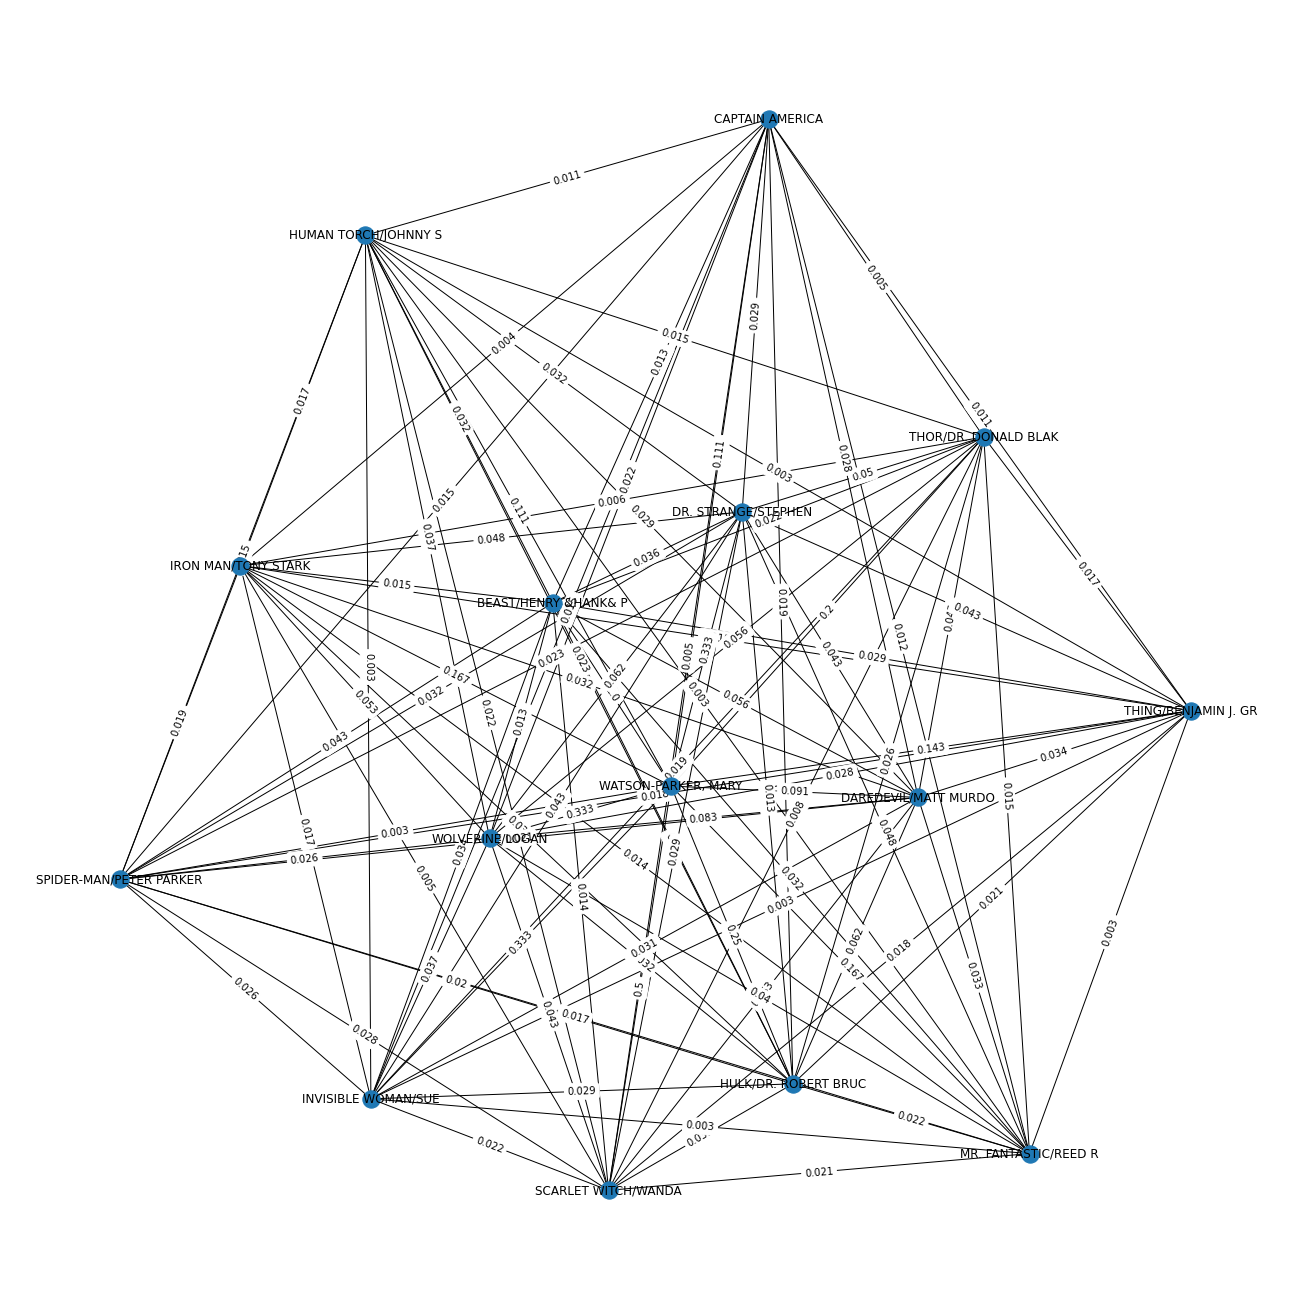

Plot of the graph after removing the links and identify the two nodes: 


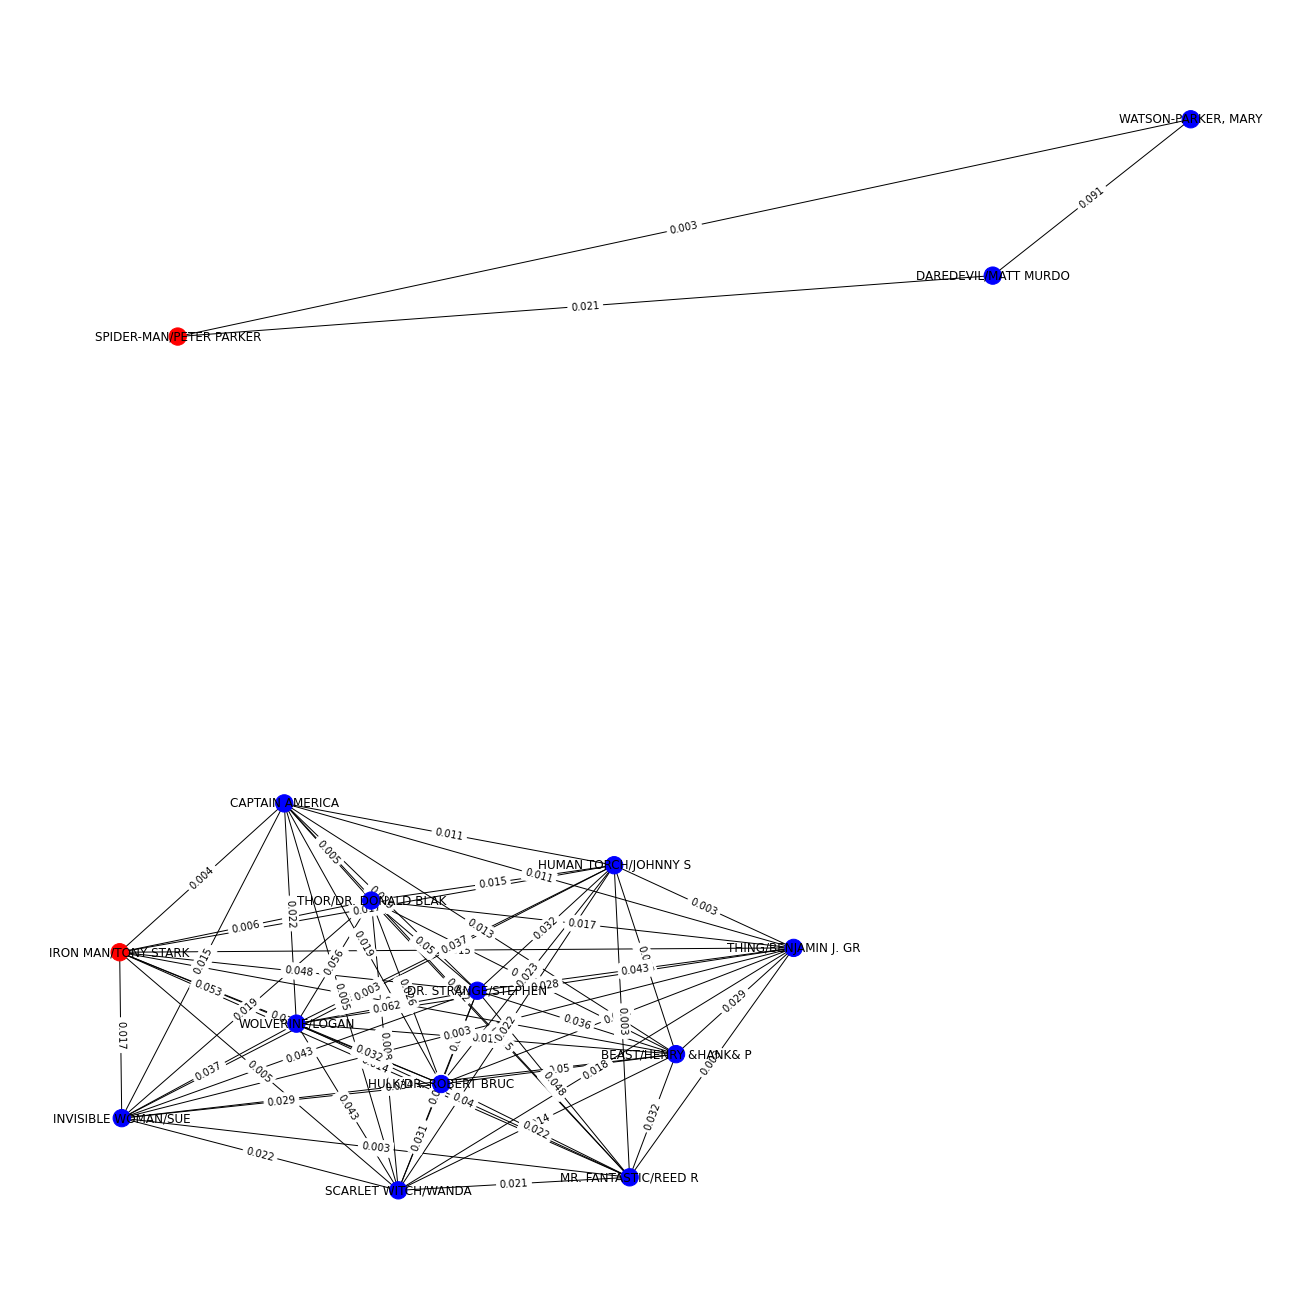

In [85]:
controller_system()

# Command Line (test with Python)

What is the most popular pair of heroes (often appearing together in the comics)?

In [140]:
pairs = {}
for h1, h2 in df_hero_net.to_numpy():
    if h1 != h2:
        if (h1, h2) in pairs:
            pairs[(h1,h2)] +=1
        else:
            pairs[(h1,h2)] = 1

sorted(pairs.items(), key=lambda item: item[1], reverse = True)[0]

(('PATRIOT/JEFF MACE', 'MISS AMERICA/MADELIN'), 1267)

Number of comics per hero.

The average number of heroes in comics.

# Algorithmic Question

In [187]:
directions = list(input())

In [189]:
directions

['D', 'R', 'U']

In [190]:
def paths(r,c,visited,directions,app_count):
    print(directions)
    if directions == []:
        app_count+=1
        print(app_count)
        return app_count
    for k in range(len(directions)):
        if directions[k] == 'R' and c == 0:
            c += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            else:
                return app_count
            c+=1
            if [r,c] not in visited and [r,c-1] not in visited:
                visited.append([r,c-1])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c-1])
                visited.remove([r,c])
        if directions[k] == 'R' and c == 1:
            c += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])

        if directions[k] == 'U' and r == 2:
            r -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            else:
                return app_count
            r -= 1
            if [r,c] not in visited and [r-1,c] not in visited:
                visited.append([r-1,c])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r-1,c])
                visited.remove([r,c])
        if directions[k] == 'U' and r == 1:
            r -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
                
        if directions[k] == 'D' and r == 0:
            r += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            else:
                return app_count

            r += 1
            if [r,c] not in visited and [r-1,c] not in visited:
                visited.append([r-1,c])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r-1,c])
                visited.remove([r,c])
        if directions[k] == 'D' and r == 1:
            r += 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
        
        if directions[k] == 'L' and c == 2:
            c -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                print(type(app_count))
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
            c -= 1
            if [r,c] not in visited and [r,c+1] not in visited:
                visited.append([r,c+1])
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c+1])
                visited.remove([r,c])
        if directions[k] == 'L' and c == 1:
            c -= 1
            if [r,c] not in visited:
                visited.append([r,c])
                app_count = paths(r,c,visited,directions[k+1:],app_count)
                visited.remove([r,c])
        else:
            return app_count
         
        return app_count

In [191]:
count=0
for r in range(3):
    for c in range(3):
        visited = [[r,c]]
        app_count=0
        print('starting point',r,c)
        app_count = paths(r,c,visited,directions,app_count)
        count += app_count

starting point 0 0
['D', 'R', 'U']
['R', 'U']
['U']
[]
1
['U']
[]
2
['R', 'U']
['U']
[]
3
[]
4
['U']
[]
5
[]
6
starting point 0 1
['D', 'R', 'U']
['R', 'U']
['U']
[]
1
['R', 'U']
['U']
[]
2
[]
3
starting point 0 2
['D', 'R', 'U']
['R', 'U']
['R', 'U']
starting point 1 0
['D', 'R', 'U']
['R', 'U']
['U']
[]
1
[]
2
['U']
[]
3
[]
4
starting point 1 1
['D', 'R', 'U']
['R', 'U']
['U']
[]
1
[]
2
starting point 1 2
['D', 'R', 'U']
['R', 'U']
starting point 2 0
['D', 'R', 'U']
starting point 2 1
['D', 'R', 'U']
starting point 2 2
['D', 'R', 'U']


In [192]:
count

15